In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from test_utils import *
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

path = '/Users/bwq666/Documents/GitHub/nonparametric-cli-test/Plots'; chdir(path)

In [46]:
#'/Users/bwq666/Documents/GitHub/nonparametric-cli-test/sim_data/DMLvsCox.pkl'
if 1:
    with open('/Users/bwq666/Documents/BoxHed/sim_data/DMLvsCox1.pkl','rb') as f:
        sim_data = pickle.load(f)

In [47]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}')
sns.set_theme(style='whitegrid',palette='pastel')

In [48]:
p_value = lambda x: 1-BM_supnorm_cdf(np.sqrt(x[2])*x[0]/np.sqrt(x[1])) # x = (statistic, variance, samplesize)
sim_data['p_orth'] = sim_data[['T_corrected','sigma','n_sample']].apply(p_value,axis=1)
sim_data['p_double'] = sim_data[['T_double','sigma_double','n_sample']].apply(p_value,axis=1)

In [49]:
df_pvals = pd.melt(
    sim_data, id_vars=['n_sample','alt_param','beta1','kernel_X'],value_vars=['p_double','p_cox']
)
if len(df_pvals['beta1'].unique()) > 1:
    parameter_name = r'$(\beta,k)$'
    df_pvals[parameter_name] = list(zip(df_pvals.beta1.astype(int),df_pvals.kernel_X))
else:
    parameter_name = r'dependency'
    df_pvals[parameter_name] = df_pvals.alt_param

In [50]:
df = df_pvals.rename(columns={"n_sample": r"$n$"})
df = df[(df['alt_param']==0) & (df['variable']=='p_double')]

In [177]:
df_rename = df.rename(columns={
    'n_sample':r'sample size $n$',
    'beta1':r'$\beta$',
    'kernel_X':r'kernel $\delta$'
})

In [178]:
def ecdf(data, array: bool=True):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    if not array:
        return pd.DataFrame({'x': x, 'y': y})
    else:
        return x, y

def ecdfplot(*data,**kwargs):
    data=kwargs['data']
    dfg = data.groupby([r'$\beta$',r'kernel $\delta$'])['value'].apply(ecdf, False).reset_index()
    sns.lineplot(data=dfg, x='x', y='y', hue=r'kernel $\delta$', style=r'$\beta$', palette='pastel',legend=True,dashes=[[6, 2],[2, 2, 10, 2]])


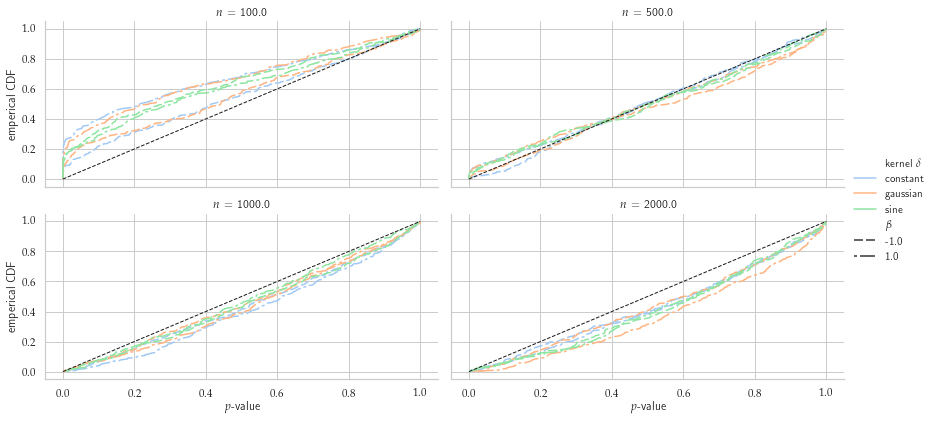

In [189]:
sns.set_theme(style='whitegrid',palette='muted',rc={'figure.figsize':(4,4)})

g = sns.FacetGrid(
    data=df_rename,col=r"$n$",col_wrap=2,height=3,aspect=2
)
g = g.map_dataframe(ecdfplot)
g.add_legend(adjust_subtitles=False, **{'frameon':False})


# g.fig.subplots_adjust(bottom=0.2)
# g.legend.set_bbox_to_anchor([0.52,0.06])
g.set_axis_labels(r'$p$-value',r'emperical CDF')
for ax in g.axes.flatten():
    # for lines, linestyle in zip(ax.lines[::-1], ['--', ':']*3):
    #     #lines.set_linestyle(linestyle)
    #     lines.set_alpha(0.7)
    ax.plot([0,1],[0,1],'k--',linewidth=1)
plt.savefig('ecdf_H0.pdf')
plt.show()

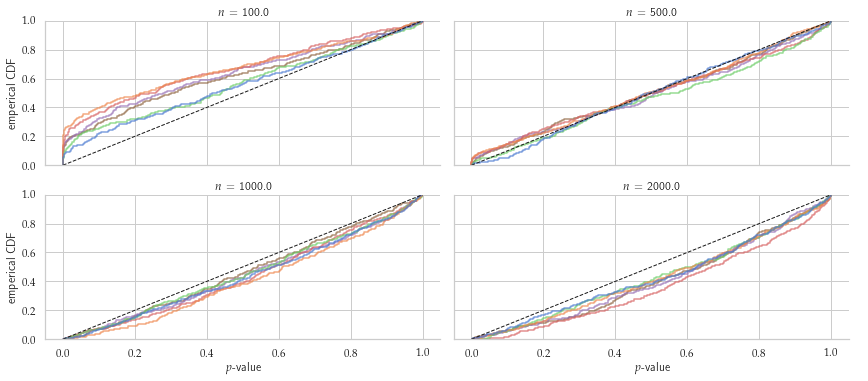

In [90]:
sns.set_theme(style='whitegrid',palette='muted',rc={'figure.figsize':(4,4)})

g = sns.displot(
    data=df,x='value',col=r"$n$",col_wrap=2,hue=parameter_name,kind='ecdf',height=3,aspect=2,legend=False
)

g.fig.subplots_adjust(bottom=0.2)
# leg.set_bbox_to_anchor([0.52,0.06])
g.add_legend(handles=legend_patches, ncol=6)
g.set_axis_labels(r'$p$-value',r'emperical CDF')
for ax in g.axes.flatten():
    for lines, linestyle in zip(ax.lines[::-1], ['--', ':']*3):
        #lines.set_linestyle(linestyle)
        lines.set_alpha(0.7)
    ax.plot([0,1],[0,1],'k--',linewidth=1)
plt.savefig('ecdf_H0.pdf')
plt.show()

In [12]:
df = df_pvals.groupby(['n_sample','alt_param','beta1','kernel_X','variable'],as_index=False).aggregate(lambda x: np.mean(x<0.05))

In [13]:
df_rename = df.rename(columns={
    'n_sample':r'sample size $n$',
    'alt_param':r'$\rho_0^2$',
    'beta1':r'$\beta$',
    'kernel_X':r'kernel $\delta$',
    'value':r'rejection rate'
})

In [14]:
df_rename['identity'] = ['']*len(df_rename)
df_rename.head(2)

,sample size $n$,$\rho_0^2$,$\beta$,kernel $\delta$,variable,rejection rate,identity
0,100.0,0,-1.0,constant,p_cox,0.0,
1,100.0,0,-1.0,constant,p_double,0.0,


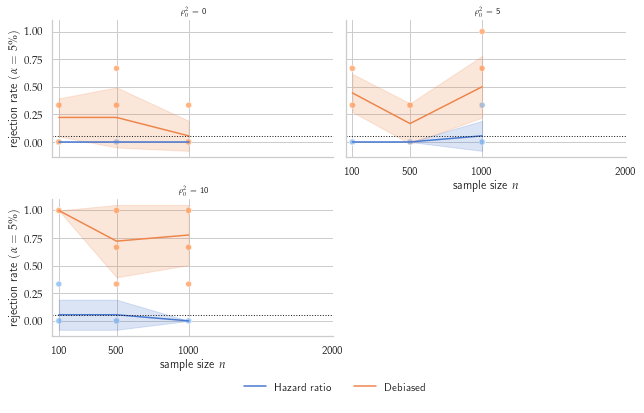

In [15]:
sns.set_theme(style='whitegrid',palette='pastel',rc={'figure.figsize':(6,6)})
g = sns.FacetGrid(df_rename, col=r'$\rho_0^2$',col_wrap=2,margin_titles=True,aspect=1.5)
g.map(
    sns.scatterplot,r'sample size $n$',r'rejection rate','variable',#,r'$\beta$',r'kernel $\delta$',
    palette='pastel'
)
lp = g.map(
    sns.lineplot,r'sample size $n$',r'rejection rate','variable',ci='sd',palette='muted'
)

g.set_axis_labels(r'sample size $n$', r'rejection rate $(\alpha = 5\%)$')
h,_ =lp.axes[0].get_legend_handles_labels()
g.add_legend(handles=h[-2:],labels=[r'Hazard ratio', r'Debiased'],ncol=2)

g.refline(y=0.05, linewidth=1, linestyle=':',color='k', clip_on=False)
g.set_titles(size='x-small')
g.fig.subplots_adjust(bottom=0.2)
leg = g._legend
leg.set_bbox_to_anchor([0.52,0.06])

#g.tight_layout()
for ax in g.axes.flat:
    ax.set_xticks([100,500,1000,2000])
    ax.set_xticklabels([100,500,1000,2000])

plt.savefig('rejectionrates.pdf')
plt.show()

### DML Example

In [37]:
if 1:
    with open('/Users/bwq666/Documents/GitHub/nonparametric-cli-test/sim_data/dml_example.pkl','rb') as f:
        sim_data = pickle.load(f)

In [38]:
data = pd.melt(
    sim_data,value_vars=['gam_plug','gam_corrected','gam_double'],
)
data['endpoints'] = data['value'].apply(lambda x: x[-1])

In [39]:
longform = data.apply(lambda x: pd.Series(x['value']),axis=1).stack().reset_index(level=1, drop=True)
longform.name = 'values'
df = data.drop('value', axis=1).join(longform)
df['sampleidx'] = df.index
df = df.reset_index()
df['time'] = np.tile(np.linspace(0,1,128),3*len(sim_data))

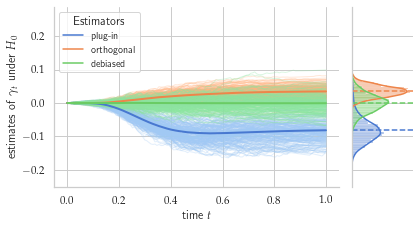

In [45]:
sns.set_theme(style='whitegrid',palette='pastel')
g = sns.JointGrid('time', 'values', data=df, ratio=4)
g.ax_marg_x.remove()
g.fig.set_figwidth(6)
g.fig.set_figheight(4)

sns.lineplot(
    data=df[df['sampleidx']%10 == 1],x='time',y='values',hue='variable',size='sampleidx',ax=g.ax_joint,
    palette='pastel',estimator=None, 
    sizes=(1,1),**{'alpha':0.3}
)

sns.lineplot(
    data=df,x='time',y='values',hue='variable',ax=g.ax_joint,ci=None,
    sizes=[2],palette='muted',lw=2
)
h,_ = g.ax_joint.get_legend_handles_labels()
g.ax_joint.legend(
    h[-3:],['plug-in','orthogonal','debiased'], 
    loc=2,title='Estimators', prop={'size': 10})

# sns.scatterplot(
#     data=df[df['sampleidx']%3 != 0],x='time',y='values',hue='variable',ax=g.ax_joint,palette='pastel',s=1.5
# )

g.ax_joint.set_xlabel(r'time $t$')
g.ax_joint.set_ylabel(r'estimates of $\gamma_t$ under $H_0$')

#g = g.refline(y=0, linewidth=1, linestyle=':',color='k', clip_on=False)

colors = sns.color_palette('muted')
for i,c in enumerate(data['variable'].unique()):
    sns.histplot(y=data['endpoints'][data['variable']==c], bins=50, stat='density', ax=g.ax_marg_y, color=colors[i],
        kde=True,kde_kws={'cut':5}
    )
    g.ax_marg_y.axhline(np.mean(data['endpoints'][data['variable']==c]),linestyle='dashed',color=colors[i])

g.figure.tight_layout()
plt.savefig('continuous_example.pdf',bbox_inches='tight', pad_inches=0)
plt.show()

In [41]:
relabel = {
    'gam_plug':r'$\hat{\gamma}_{\text{plug-in}}$',
    'gam_corrected':r'$\hat{\gamma}_{\text{double}}$ w/o sample split',
    'gam_double':r'$\hat{\gamma}_{\text{double}}$ w/ sample split'
}
data['Estimator'] = data['variable'].apply(lambda x: relabel[x])

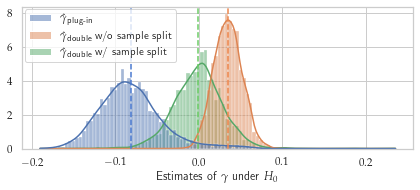

In [43]:
sns.set(style='whitegrid',rc={'figure.figsize':(6,2.8)},palette='deep')
ax = sns.histplot(data,x='endpoints',hue='Estimator',bins=100,stat='density',kde=True,legend=True,kde_kws={'cut':0.5});
plt.ylabel(None)
plt.xlabel(r'Estimates of $\gamma$ under $H_0$')
sns.move_legend(ax,'lower center', title=None, bbox_to_anchor=(0.2,0.57),frameon=True)

for i,c in enumerate(data['variable'].unique()):
    ax.axvline(np.mean(data['endpoints'][data['variable']==c]),linestyle='dashed',color=colors[i])
plt.tight_layout()
plt.savefig('endpoints_example.pdf')
plt.show()